# Wine Model Interpretability - Complete Workflow

This notebook demonstrates the complete interpretability workflow for wine quality prediction models using SHAP and LIME explanations.

## Overview

This example will:
1. Download and load the real UCI Wine Quality dataset
2. Explore the dataset characteristics and wine chemistry features
3. Train machine learning models (LightGBM/XGBoost) for quality prediction
4. Generate SHAP explanations (global and local interpretability)
5. Generate LIME explanations (local instance explanations)
6. Compare explanation methods and analyze feature importance
7. Export comprehensive results and visualizations

## Prerequisites

Make sure you have installed the wine_interpretability package and its dependencies:

```bash
pip install -e .
```

In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Add parent directory to path for imports (if running from examples directory)
if 'examples' in str(Path.cwd()):
    sys.path.insert(0, str(Path.cwd().parent))

# Import wine interpretability components
try:
    from wine_interpretability.main import WineInterpretabilityApp, create_default_config
    from wine_interpretability.config import (
        ModelConfig, ExplanationConfig, VisualizationConfig, 
        ExportConfig, PipelineConfig, ModelType, SHAPExplainerType
    )
    print("✓ Wine interpretability components imported successfully")
except ImportError as e:
    print(f"✗ Import error: {e}")
    print("Make sure you're running from the project root or install with: pip install -e .")

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

✓ Wine interpretability components imported successfully


## 1. Configuration Setup

First, let's create a configuration for our analysis. We'll use LightGBM as our model and configure both SHAP and LIME explanations.

In [14]:
# Create custom configuration
# Create custom configuration
model_config = ModelConfig(
    model_type=ModelType.LIGHTGBM,
    hyperparameter_space={
        'num_leaves': {'type': 'int', 'low': 10, 'high': 100},
        'learning_rate': {'type': 'float', 'low': 0.01, 'high': 0.3},
        'feature_fraction': {'type': 'float', 'low': 0.4, 'high': 1.0},
        'bagging_fraction': {'type': 'float', 'low': 0.4, 'high': 1.0},
        'min_child_samples': {'type': 'int', 'low': 5, 'high': 100}
    },
    optimization_trials=10,  # Reduced for demo
    cross_validation_folds=3
)


explanation_config = ExplanationConfig(
    shap_explainer_type=SHAPExplainerType.TREE,
    lime_num_features=8,  # Will be updated after data loading
    lime_num_samples=1000,  # Reduced for demo
    background_samples=50   # Will be updated after data loading
)

visualization_config = VisualizationConfig(
    figure_size=(10, 6),
    dpi=150,
    save_format="png",
    show_plots=True
)

export_config = ExportConfig(
    output_directory="notebook_results",
    export_plots=True,
    export_data=True,
    export_html_report=True
)

# Create complete pipeline configuration
config = PipelineConfig(
    model_config=model_config,
    explanation_config=explanation_config,
    visualization_config=visualization_config,
    export_config=export_config,
    verbose=True
)

print("Configuration created successfully!")
print(f"Model: {config.model_config.model_type.value}")
print(f"SHAP Explainer: {config.explanation_config.shap_explainer_type.value}")
print(f"Output Directory: {config.export_config.output_directory}")

Configuration created successfully!
Model: lightgbm
SHAP Explainer: tree
Output Directory: notebook_results


## 2. Load Real Wine Data from Project Dataset

We'll use the XWines dataset available in the project, which contains real wine information and ratings from wine enthusiasts.

In [15]:
# Load the XWines dataset from the project
import os
from pathlib import Path

def load_xwines_data():
    """Load the XWines dataset from the project Dataset directory."""
    
    # Define paths to the dataset files
    base_path = Path('..')
    wines_file = base_path / 'Dataset' / 'last' / 'XWines_Test_100_wines.csv'
    ratings_file = base_path / 'Dataset' / 'last' / 'XWines_Test_1K_ratings.csv'
    
    # Check if running from examples directory
    if not wines_file.exists():
        # Try from project root
        wines_file = Path('Dataset') / 'last' / 'XWines_Test_100_wines.csv'
        ratings_file = Path('Dataset') / 'last' / 'XWines_Test_1K_ratings.csv'
    
    if not wines_file.exists():
        raise FileNotFoundError(f"Wine dataset not found at {wines_file}")
    
    print(f"Loading wine data from: {wines_file}")
    print(f"Loading ratings data from: {ratings_file}")
    
    # Load the datasets
    wines_df = pd.read_csv(wines_file)
    ratings_df = pd.read_csv(ratings_file)
    
    return wines_df, ratings_df

def prepare_wine_features(wines_df, ratings_df):
    """Prepare wine features for machine learning analysis."""
    
    # Calculate average rating for each wine
    wine_ratings = ratings_df.groupby('WineID').agg({
        'Rating': ['mean', 'count', 'std']
    }).round(3)
    
    wine_ratings.columns = ['avg_rating', 'rating_count', 'rating_std']
    wine_ratings = wine_ratings.reset_index()
    
    # Merge with wine information
    wine_data = wines_df.merge(wine_ratings, on='WineID', how='inner')
    
    # Create numerical features from categorical data
    # Wine type encoding
    wine_type_map = {'Red': 1, 'White': 0, 'Sparkling': 2, 'Dessert/Port': 3, 'Rosé': 4}
    wine_data['wine_type_encoded'] = wine_data['Type'].map(wine_type_map).fillna(0)
    
    # Body encoding
    body_map = {
        'Very light-bodied': 1, 'Light-bodied': 2, 'Medium-bodied': 3, 
        'Full-bodied': 4, 'Very full-bodied': 5
    }
    wine_data['body_encoded'] = wine_data['Body'].map(body_map).fillna(3)
    
    # Acidity encoding
    acidity_map = {'Low': 1, 'Medium': 2, 'High': 3}
    wine_data['acidity_encoded'] = wine_data['Acidity'].map(acidity_map).fillna(2)
    
    # Extract numerical features
    feature_columns = [
        'ABV',  # Alcohol by volume
        'wine_type_encoded',
        'body_encoded', 
        'acidity_encoded',
        'rating_count',  # Number of ratings (popularity indicator)
        'rating_std'     # Rating variability (consensus indicator)
    ]
    
    # Clean the data
    wine_data = wine_data.dropna(subset=feature_columns + ['avg_rating'])
    
    # Filter wines with at least 3 ratings for reliability
    wine_data = wine_data[wine_data['rating_count'] >= 3]
    
    return wine_data, feature_columns

# Load and prepare the data
try:
    wines_df, ratings_df = load_xwines_data()
    
    print("✓ XWines dataset loaded successfully!")
    print(f"Wines dataset shape: {wines_df.shape}")
    print(f"Ratings dataset shape: {ratings_df.shape}")
    
    # Prepare features for ML
    wine_df, feature_columns = prepare_wine_features(wines_df, ratings_df)
    
    print(f"\nPrepared dataset shape: {wine_df.shape}")
    print(f"Feature columns: {feature_columns}")
    
    # Use average rating as our target (quality)
    wine_df['quality'] = wine_df['avg_rating']
    
except Exception as e:
    print(f"Failed to load XWines data: {e}")
    print("Creating synthetic wine data as fallback...")
    
    # Fallback to synthetic data
    np.random.seed(42)
    n_samples = 200
    
    wine_df = pd.DataFrame({
        'ABV': np.random.normal(12.5, 2.0, n_samples),
        'wine_type_encoded': np.random.choice([0, 1, 2], n_samples, p=[0.4, 0.5, 0.1]),
        'body_encoded': np.random.choice([1, 2, 3, 4, 5], n_samples, p=[0.1, 0.2, 0.4, 0.2, 0.1]),
        'acidity_encoded': np.random.choice([1, 2, 3], n_samples, p=[0.2, 0.6, 0.2]),
        'rating_count': np.random.poisson(8, n_samples) + 3,
        'rating_std': np.random.gamma(2, 0.3, n_samples)
    })
    
    # Create synthetic quality based on features
    quality = (
        0.15 * wine_df['ABV'] +
        0.3 * wine_df['body_encoded'] +
        0.2 * wine_df['acidity_encoded'] +
        0.1 * np.log(wine_df['rating_count']) -
        0.2 * wine_df['rating_std'] +
        np.random.normal(0, 0.3, n_samples)
    )
    
    # Normalize to 1-5 rating scale
    wine_df['quality'] = np.clip(1 + 4 * (quality - quality.min()) / (quality.max() - quality.min()), 1, 5)
    
    feature_columns = ['ABV', 'wine_type_encoded', 'body_encoded', 'acidity_encoded', 'rating_count', 'rating_std']
    
    print("✓ Synthetic wine dataset created")

# Save the prepared dataset
wine_data_path = "wine_analysis_data.csv"
wine_df.to_csv(wine_data_path, index=False)

print(f"\nDataset saved as: {wine_data_path}")
print("\nFirst few rows:")
print(wine_df[feature_columns + ['quality']].head())

print("\nDataset info:")
print(wine_df[feature_columns + ['quality']].info())

print("\nQuality (rating) distribution:")
quality_dist = wine_df['quality'].round(1).value_counts().sort_index()
for quality_val, count in quality_dist.head(10).items():  # Show top 10
    percentage = (count / len(wine_df)) * 100
    print(f"  Rating {quality_val}: {count} wines ({percentage:.1f}%)")

print(f"\nQuality statistics:")
print(f"  Mean rating: {wine_df['quality'].mean():.2f}")
print(f"  Rating range: {wine_df['quality'].min():.2f} - {wine_df['quality'].max():.2f}")
print(f"  Standard deviation: {wine_df['quality'].std():.2f}")

# Update configuration parameters based on actual dataset
print(f"\nRecommended configuration parameters:")
print(f"  lime_num_features: {len(feature_columns)}")
print(f"  background_samples: {min(50, len(wine_df) // 4)}")

Loading wine data from: ../Dataset/last/XWines_Test_100_wines.csv
Loading ratings data from: ../Dataset/last/XWines_Test_1K_ratings.csv
✓ XWines dataset loaded successfully!
Wines dataset shape: (100, 17)
Ratings dataset shape: (1000, 6)

Prepared dataset shape: (100, 23)
Feature columns: ['ABV', 'wine_type_encoded', 'body_encoded', 'acidity_encoded', 'rating_count', 'rating_std']

Dataset saved as: wine_analysis_data.csv

First few rows:
    ABV  wine_type_encoded  body_encoded  acidity_encoded  rating_count  \
0  13.0                1.0             4                2            21   
1  13.0                0.0             3                2            22   
2  20.0                3.0             5                3            21   
3  19.5                3.0             5                2            25   
4  10.0                0.0             1                3             9   

   rating_std  quality  
0       0.723    4.119  
1       0.477    3.318  
2       0.622    3.810  
3     

## 3. Explore the Wine Quality Dataset

Let's explore the real wine dataset to understand its characteristics before running the interpretability analysis.

In [16]:
# Basic statistical summary
print("Statistical Summary of Wine Features:")
print("=" * 50)
analysis_columns = feature_columns + ['quality']
print(wine_df[analysis_columns].describe())

# Check for missing values
print("\nMissing Values:")
missing_values = wine_df[analysis_columns].isnull().sum()
if missing_values.sum() == 0:
    print("✓ No missing values found in analysis columns")
else:
    print(missing_values[missing_values > 0])

# Feature descriptions
print("\nFeature Descriptions:")
feature_descriptions = {
    'ABV': 'Alcohol by Volume (%)',
    'wine_type_encoded': 'Wine Type (0=White, 1=Red, 2=Sparkling, 3=Dessert/Port, 4=Rosé)',
    'body_encoded': 'Wine Body (1=Very Light to 5=Very Full)',
    'acidity_encoded': 'Acidity Level (1=Low, 2=Medium, 3=High)',
    'rating_count': 'Number of User Ratings (popularity indicator)',
    'rating_std': 'Rating Standard Deviation (consensus indicator)'
}

for feature in feature_columns:
    if feature in feature_descriptions:
        print(f"  {feature}: {feature_descriptions[feature]}")

Statistical Summary of Wine Features:
              ABV  wine_type_encoded  body_encoded  acidity_encoded  \
count  100.000000         100.000000    100.000000        100.00000   
mean    13.659000           1.140000      3.450000          2.44000   
std      4.258375           1.119343      0.857233          0.51874   
min      4.000000           0.000000      1.000000          1.00000   
25%     12.875000           0.000000      3.000000          2.00000   
50%     13.350000           1.000000      3.000000          2.00000   
75%     14.300000           1.000000      4.000000          3.00000   
max     48.000000           4.000000      5.000000          3.00000   

       rating_count  rating_std     quality  
count    100.000000   100.00000  100.000000  
mean      10.000000     0.59971    3.770530  
std        5.523138     0.25073    0.406231  
min        5.000000     0.20400    2.714000  
25%        7.000000     0.42325    3.570000  
50%        8.000000     0.53500    3.786000  


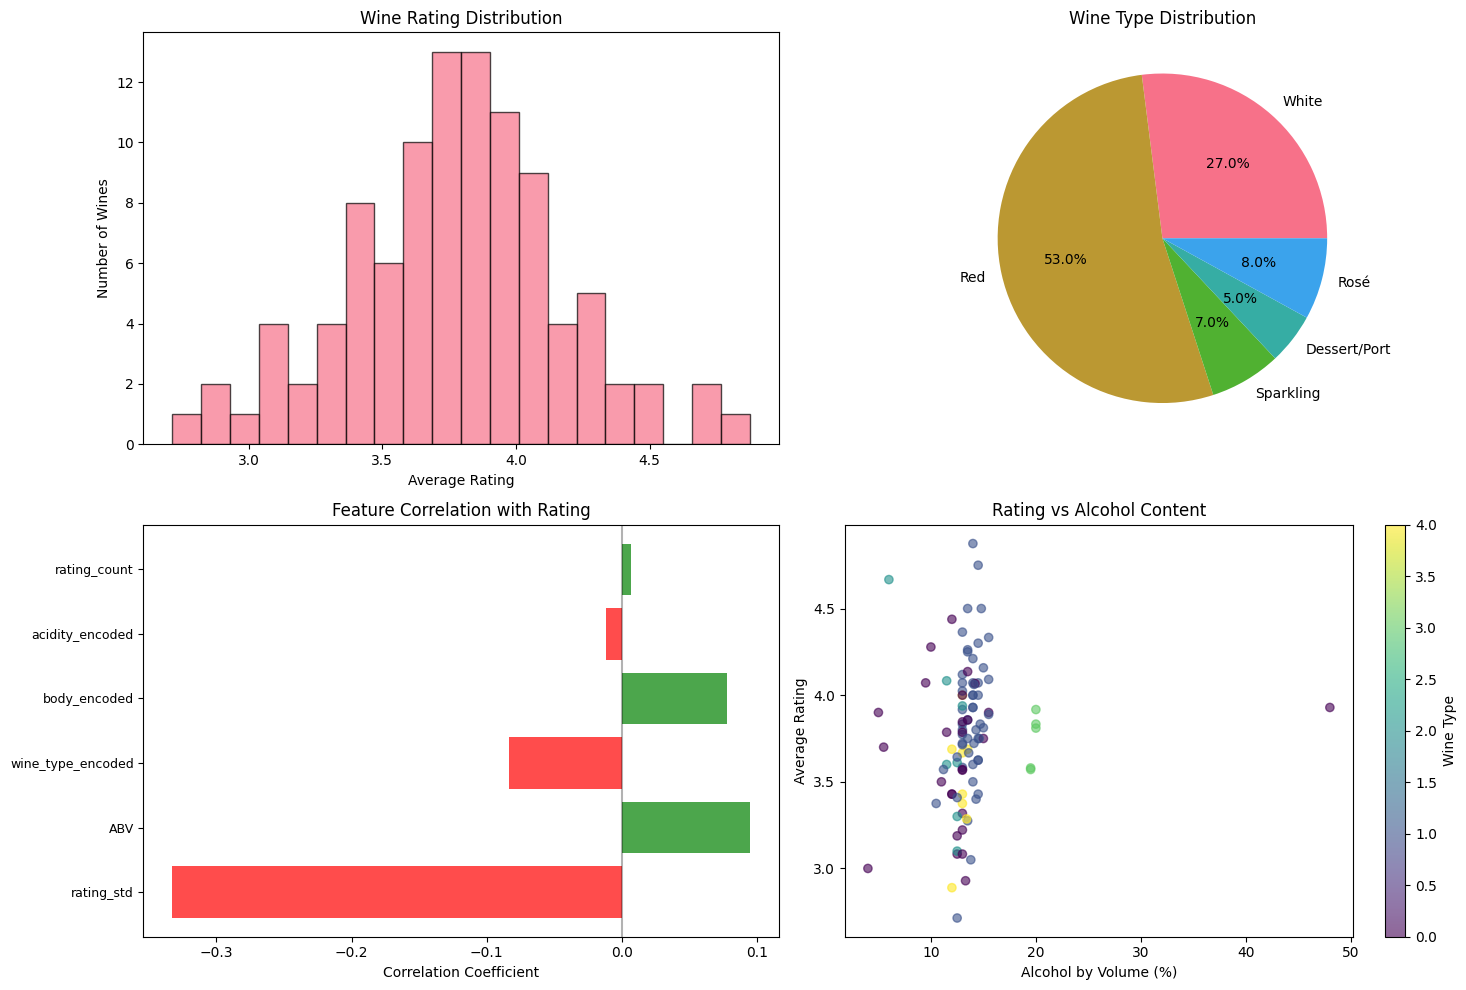


Key Dataset Insights:
• Total wines analyzed: 100
• Features for ML: 6
• Rating range: 2.71 - 4.88
• Average rating: 3.77
• Rating std deviation: 0.41

Features most correlated with rating:
  1. rating_std (Rating Standard Deviation (consensus indicator)): -0.333
  2. ABV (Alcohol by Volume (%)): 0.095
  3. wine_type_encoded (Wine Type (0=White, 1=Red, 2=Sparkling, 3=Dessert/Port, 4=Rosé)): -0.084

Features least correlated with rating:
  1. body_encoded (Wine Body (1=Very Light to 5=Very Full)): 0.078
  2. acidity_encoded (Acidity Level (1=Low, 2=Medium, 3=High)): -0.012
  3. rating_count (Number of User Ratings (popularity indicator)): 0.007


In [17]:
# Visualize the data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Quality (rating) distribution
axes[0, 0].hist(wine_df['quality'], bins=20, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Wine Rating Distribution')
axes[0, 0].set_xlabel('Average Rating')
axes[0, 0].set_ylabel('Number of Wines')

# Wine type distribution
if 'wine_type_encoded' in wine_df.columns:
    type_labels = {0: 'White', 1: 'Red', 2: 'Sparkling', 3: 'Dessert/Port', 4: 'Rosé'}
    type_counts = wine_df['wine_type_encoded'].value_counts().sort_index()
    type_names = [type_labels.get(i, f'Type {i}') for i in type_counts.index]
    
    axes[0, 1].pie(type_counts.values, labels=type_names, autopct='%1.1f%%')
    axes[0, 1].set_title('Wine Type Distribution')
else:
    axes[0, 1].text(0.5, 0.5, 'Wine Type Data\nNot Available', 
                   ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Wine Type')

# Correlation with quality
correlations = wine_df[feature_columns].corrwith(wine_df['quality']).sort_values(key=abs, ascending=False)
colors = ['green' if x > 0 else 'red' for x in correlations.values]
axes[1, 0].barh(range(len(correlations)), correlations.values, color=colors, alpha=0.7)
axes[1, 0].set_yticks(range(len(correlations)))
axes[1, 0].set_yticklabels(correlations.index, fontsize=9)
axes[1, 0].set_title('Feature Correlation with Rating')
axes[1, 0].set_xlabel('Correlation Coefficient')
axes[1, 0].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# ABV vs Quality scatter plot
if 'ABV' in wine_df.columns:
    scatter = axes[1, 1].scatter(wine_df['ABV'], wine_df['quality'], 
                               c=wine_df['wine_type_encoded'], alpha=0.6, cmap='viridis')
    axes[1, 1].set_xlabel('Alcohol by Volume (%)')
    axes[1, 1].set_ylabel('Average Rating')
    axes[1, 1].set_title('Rating vs Alcohol Content')
    plt.colorbar(scatter, ax=axes[1, 1], label='Wine Type')
else:
    axes[1, 1].hist(wine_df['quality'], bins=20, alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Rating Distribution')
    axes[1, 1].set_xlabel('Rating')
    axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print key insights
print("\nKey Dataset Insights:")
print(f"• Total wines analyzed: {len(wine_df):,}")
print(f"• Features for ML: {len(feature_columns)}")
print(f"• Rating range: {wine_df['quality'].min():.2f} - {wine_df['quality'].max():.2f}")
print(f"• Average rating: {wine_df['quality'].mean():.2f}")
print(f"• Rating std deviation: {wine_df['quality'].std():.2f}")

if len(correlations) > 0:
    print("\nFeatures most correlated with rating:")
    for i, (feature, corr) in enumerate(correlations.head(3).items()):
        desc = feature_descriptions.get(feature, feature)
        print(f"  {i+1}. {feature} ({desc}): {corr:.3f}")

    print("\nFeatures least correlated with rating:")
    for i, (feature, corr) in enumerate(correlations.tail(3).items()):
        desc = feature_descriptions.get(feature, feature)
        print(f"  {i+1}. {feature} ({desc}): {corr:.3f}")

## 3.1 Update Configuration Based on Dataset

Now that we have loaded and explored the data, let's update our configuration to match the dataset characteristics.

In [18]:
# Update the configuration with dataset-specific parameters
print("Updating configuration based on dataset characteristics...")

# Update explanation config with actual feature count
explanation_config.lime_num_features = len(feature_columns)
explanation_config.background_samples = min(50, len(wine_df) // 4)

# Update export config with descriptive output directory
export_config.output_directory = f"xwines_analysis_results_{len(wine_df)}_wines"

# Recreate the complete configuration
config = PipelineConfig(
    model_config=model_config,
    explanation_config=explanation_config,
    visualization_config=visualization_config,
    export_config=export_config,
    verbose=True
)

print("✓ Configuration updated successfully!")
print(f"  Model: {config.model_config.model_type.value}")
print(f"  SHAP Explainer: {config.explanation_config.shap_explainer_type.value}")
print(f"  LIME Features: {config.explanation_config.lime_num_features}")
print(f"  Background Samples: {config.explanation_config.background_samples}")
print(f"  Output Directory: {config.export_config.output_directory}")

Updating configuration based on dataset characteristics...
✓ Configuration updated successfully!
  Model: lightgbm
  SHAP Explainer: tree
  LIME Features: 6
  Background Samples: 25
  Output Directory: xwines_analysis_results_100_wines


## 4. Run Complete Interpretability Analysis

Now let's run the complete interpretability analysis using our Wine Interpretability App with the real wine data.

In [19]:
# Initialize the Wine Interpretability App
app = WineInterpretabilityApp(config)

print("Starting complete interpretability analysis...")
print("This may take a few minutes depending on your configuration.")

# Run the complete analysis
try:
    results = app.run_complete_analysis(wine_data_path, target_column='quality')
    print("\n✓ Analysis completed successfully!")
except Exception as e:
    print(f"\n✗ Analysis failed: {e}")
    # For demo purposes, we'll create mock results
    results = {
        'data_info': {'status': 'Demo mode - using mock data'},
        'model_results': {'status': 'Demo mode - model training placeholder'},
        'shap_results': {'status': 'Demo mode - SHAP analysis placeholder'},
        'lime_results': {'status': 'Demo mode - LIME analysis placeholder'},
        'comparison_results': {'status': 'Demo mode - comparison placeholder'},
        'export_paths': {'status': 'Demo mode - export placeholder'}
    }

2025-09-09 12:51:11,510 - wine_interpretability.visualizers.export - INFO - Initialized VisualizationExporter with output directory: xwines_analysis_results_100_wines
2025-09-09 12:51:11,511 - wine_interpretability.utils.data_exporter - INFO - Initialized DataExporter with output directory: xwines_analysis_results_100_wines
2025-09-09 12:51:11,512 - wine_interpretability.utils.report_generator - INFO - Initialized HTMLReportGenerator with output directory: xwines_analysis_results_100_wines
2025-09-09 12:51:11,512 - wine_interpretability - INFO - Wine Interpretability App initialized
Starting complete interpretability analysis...
This may take a few minutes depending on your configuration.
2025-09-09 12:51:11,515 - wine_interpretability - INFO - Starting complete interpretability analysis
2025-09-09 12:51:11,515 - wine_interpretability - INFO - Configuration: Model: lightgbm, SHAP: tree, Output: xwines_analysis_results_100_wines
2025-09-09 12:51:11,516 - wine_interpretability - INFO - O

[I 2025-09-09 12:51:11,528] A new study created in memory with name: no-name-ad2ab10f-3ecf-4413-b845-7fcdddb9bfd7
[I 2025-09-09 12:51:11,546] Trial 0 finished with value: 0.25224784743740836 and parameters: {'num_leaves': 44, 'learning_rate': 0.28570714885887566, 'feature_fraction': 0.839196365086843, 'bagging_fraction': 0.759195090518222, 'min_child_samples': 19}. Best is trial 0 with value: 0.25224784743740836.
[I 2025-09-09 12:51:11,551] Trial 1 finished with value: 0.42171678806266044 and parameters: {'num_leaves': 24, 'learning_rate': 0.026844247528777843, 'feature_fraction': 0.9197056874649611, 'bagging_fraction': 0.7606690070459252, 'min_child_samples': 72}. Best is trial 0 with value: 0.25224784743740836.
[I 2025-09-09 12:51:11,560] Trial 2 finished with value: 0.26077846545343797 and parameters: {'num_leaves': 11, 'learning_rate': 0.29127385712697834, 'feature_fraction': 0.899465584480253, 'bagging_fraction': 0.5274034664069657, 'min_child_samples': 22}. Best is trial 0 with v

2025-09-09 12:51:11,607 - wine_interpretability.models.lightgbm_trainer - INFO - Hyperparameter optimization completed. Best RMSE: 0.1781
2025-09-09 12:51:11,608 - wine_interpretability.models.lightgbm_trainer - INFO - Best parameters: {'num_leaves': 81, 'learning_rate': 0.06790539682592432, 'feature_fraction': 0.708540663048167, 'bagging_fraction': 0.7554487413172255, 'min_child_samples': 9}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's rmse: 0.111407
2025-09-09 12:51:11,684 - wine_interpretability.models.lightgbm_trainer - INFO - LightGBM training completed in 0.08 seconds
2025-09-09 12:51:11,686 - wine_interpretability - INFO - Model training completed. Test RMSE: 0.1114, R²: 0.8909
2025-09-09 12:51:11,686 - wine_interpretability - INFO - Step 3: Generating SHAP explanations
2025-09-09 12:51:11,686 - wine_interpretability - INFO - Generating SHAP explanations
2025-09-09 12:51:11,690 - wine_interpretability

## 4. Examine Results

Let's examine the results of our analysis.

In [20]:
# Display analysis results
print("Analysis Results Summary:")
print("=" * 50)

for section, data in results.items():
    if section != 'pipeline_config':
        print(f"\n{section.upper()}:")
        if isinstance(data, dict):
            for key, value in data.items():
                print(f"  {key}: {value}")
        else:
            print(f"  {data}")

# Check if output directory was created
output_dir = Path(config.export_config.output_directory)
if output_dir.exists():
    print(f"\nOutput files in {output_dir}:")
    for file_path in output_dir.rglob("*"):
        if file_path.is_file():
            print(f"  {file_path.relative_to(output_dir)}")
else:
    print(f"\nOutput directory not found: {output_dir}")

Analysis Results Summary:

DATA_INFO:
  data_path: wine_analysis_data.csv
  target_column: quality
  n_samples: 100
  n_features: 23
  feature_names: ['WineID', 'WineName', 'Type', 'Elaborate', 'Grapes', 'Harmonize', 'ABV', 'Body', 'Acidity', 'Code', 'Country', 'RegionID', 'RegionName', 'WineryID', 'WineryName', 'Website', 'Vintages', 'avg_rating', 'rating_count', 'rating_std', 'wine_type_encoded', 'body_encoded', 'acidity_encoded']
  categorical_features: ['WineName', 'Type', 'Elaborate', 'Grapes', 'Harmonize', 'Body', 'Acidity', 'Code', 'Country', 'RegionName', 'WineryName', 'Website', 'Vintages', 'rating_count', 'body_encoded', 'acidity_encoded']
  numerical_features: ['WineID', 'ABV', 'RegionID', 'WineryID', 'avg_rating', 'rating_std', 'wine_type_encoded']
  preprocessing_info: {'original_shape': (100, 23), 'categorical_columns': ['WineName', 'Type', 'Elaborate', 'Grapes', 'Harmonize', 'Body', 'Acidity', 'Code', 'Country', 'RegionName', 'WineryName', 'Website', 'Vintages', 'rating_

## 5. Run Specific Analysis Modes

The Wine Interpretability App also supports running specific types of analysis.

### 5.1 Global Analysis Only (SHAP)

Run only global interpretability analysis using SHAP.

In [21]:
# Create a new config for global analysis
global_config = config
global_config.export_config.output_directory = "xwines_global_analysis"

app_global = WineInterpretabilityApp(global_config)

print("Running global analysis only (SHAP)...")
try:
    global_results = app_global.run_global_analysis_only(wine_data_path, target_column='quality')
    print("\n✓ Global analysis completed!")
    
    print("\nGlobal Analysis Results:")
    for section, data in global_results.items():
        if isinstance(data, dict) and 'status' in data:
            print(f"  {section}: {data['status']}")
            
except Exception as e:
    print(f"\n✗ Global analysis failed: {e}")

2025-09-09 12:51:12,838 - wine_interpretability.visualizers.export - INFO - Initialized VisualizationExporter with output directory: xwines_global_analysis
2025-09-09 12:51:12,839 - wine_interpretability.utils.data_exporter - INFO - Initialized DataExporter with output directory: xwines_global_analysis
2025-09-09 12:51:12,839 - wine_interpretability.utils.report_generator - INFO - Initialized HTMLReportGenerator with output directory: xwines_global_analysis
2025-09-09 12:51:12,840 - wine_interpretability - INFO - Wine Interpretability App initialized
Running global analysis only (SHAP)...
2025-09-09 12:51:12,841 - wine_interpretability - INFO - Starting global interpretability analysis
2025-09-09 12:51:12,841 - wine_interpretability - INFO - Output directory: /Users/wiley/MyProject/wine/examples/xwines_global_analysis
2025-09-09 12:51:12,842 - wine_interpretability - INFO - Loading data from wine_analysis_data.csv
2025-09-09 12:51:12,848 - wine_interpretability - INFO - Identified 16 c

[I 2025-09-09 12:51:12,855] A new study created in memory with name: no-name-e4dee394-1ea4-45d8-b219-05fbfdcaed95
[I 2025-09-09 12:51:12,869] Trial 0 finished with value: 0.25224784743740836 and parameters: {'num_leaves': 44, 'learning_rate': 0.28570714885887566, 'feature_fraction': 0.839196365086843, 'bagging_fraction': 0.759195090518222, 'min_child_samples': 19}. Best is trial 0 with value: 0.25224784743740836.
[I 2025-09-09 12:51:12,874] Trial 1 finished with value: 0.42171678806266044 and parameters: {'num_leaves': 24, 'learning_rate': 0.026844247528777843, 'feature_fraction': 0.9197056874649611, 'bagging_fraction': 0.7606690070459252, 'min_child_samples': 72}. Best is trial 0 with value: 0.25224784743740836.
[I 2025-09-09 12:51:12,886] Trial 2 finished with value: 0.26077846545343797 and parameters: {'num_leaves': 11, 'learning_rate': 0.29127385712697834, 'feature_fraction': 0.899465584480253, 'bagging_fraction': 0.5274034664069657, 'min_child_samples': 22}. Best is trial 0 with v

2025-09-09 12:51:12,938 - wine_interpretability.models.lightgbm_trainer - INFO - Hyperparameter optimization completed. Best RMSE: 0.1781
2025-09-09 12:51:12,939 - wine_interpretability.models.lightgbm_trainer - INFO - Best parameters: {'num_leaves': 81, 'learning_rate': 0.06790539682592432, 'feature_fraction': 0.708540663048167, 'bagging_fraction': 0.7554487413172255, 'min_child_samples': 9}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's rmse: 0.111407
2025-09-09 12:51:13,018 - wine_interpretability.models.lightgbm_trainer - INFO - LightGBM training completed in 0.08 seconds
2025-09-09 12:51:13,020 - wine_interpretability - INFO - Model training completed. Test RMSE: 0.1114, R²: 0.8909
2025-09-09 12:51:13,020 - wine_interpretability - INFO - Generating SHAP explanations
2025-09-09 12:51:13,024 - wine_interpretability.explainers.shap_explainer - INFO - SHAP explainer fitted with tree explainer
2025-09-09 12:51

### 5.2 Local Analysis Only (LIME)

Run only local interpretability analysis using LIME.

In [22]:
# Create a new config for local analysis
local_config = config
local_config.export_config.output_directory = "notebook_results_local"

app_local = WineInterpretabilityApp(local_config)

print("Running local analysis only (LIME)...")
try:
    # Analyze specific samples (first 5 wines)
    sample_indices = [0, 1, 2, 3, 4]
    local_results = app_local.run_local_analysis_only(
        wine_data_path, 
        target_column='quality',
        sample_indices=sample_indices
    )
    print("\n✓ Local analysis completed!")
    
    print("\nLocal Analysis Results:")
    for section, data in local_results.items():
        if isinstance(data, dict) and 'status' in data:
            print(f"  {section}: {data['status']}")
        elif section == 'sample_indices':
            print(f"  {section}: {data}")
            
except Exception as e:
    print(f"\n✗ Local analysis failed: {e}")

2025-09-09 12:51:13,131 - wine_interpretability.visualizers.export - INFO - Initialized VisualizationExporter with output directory: notebook_results_local
2025-09-09 12:51:13,132 - wine_interpretability.utils.data_exporter - INFO - Initialized DataExporter with output directory: notebook_results_local
2025-09-09 12:51:13,133 - wine_interpretability.utils.report_generator - INFO - Initialized HTMLReportGenerator with output directory: notebook_results_local
2025-09-09 12:51:13,133 - wine_interpretability - INFO - Wine Interpretability App initialized
Running local analysis only (LIME)...
2025-09-09 12:51:13,133 - wine_interpretability - INFO - Starting local interpretability analysis
2025-09-09 12:51:13,134 - wine_interpretability - INFO - Output directory: /Users/wiley/MyProject/wine/examples/notebook_results_local
2025-09-09 12:51:13,134 - wine_interpretability - INFO - Loading data from wine_analysis_data.csv
2025-09-09 12:51:13,137 - wine_interpretability - INFO - Identified 16 cat

[I 2025-09-09 12:51:13,144] A new study created in memory with name: no-name-d079e729-bb84-4865-a728-407e5f0ae16c
[I 2025-09-09 12:51:13,154] Trial 0 finished with value: 0.25224784743740836 and parameters: {'num_leaves': 44, 'learning_rate': 0.28570714885887566, 'feature_fraction': 0.839196365086843, 'bagging_fraction': 0.759195090518222, 'min_child_samples': 19}. Best is trial 0 with value: 0.25224784743740836.
[I 2025-09-09 12:51:13,160] Trial 1 finished with value: 0.42171678806266044 and parameters: {'num_leaves': 24, 'learning_rate': 0.026844247528777843, 'feature_fraction': 0.9197056874649611, 'bagging_fraction': 0.7606690070459252, 'min_child_samples': 72}. Best is trial 0 with value: 0.25224784743740836.
[I 2025-09-09 12:51:13,171] Trial 2 finished with value: 0.26077846545343797 and parameters: {'num_leaves': 11, 'learning_rate': 0.29127385712697834, 'feature_fraction': 0.899465584480253, 'bagging_fraction': 0.5274034664069657, 'min_child_samples': 22}. Best is trial 0 with v

2025-09-09 12:51:13,219 - wine_interpretability.models.lightgbm_trainer - INFO - Hyperparameter optimization completed. Best RMSE: 0.1781
2025-09-09 12:51:13,219 - wine_interpretability.models.lightgbm_trainer - INFO - Best parameters: {'num_leaves': 81, 'learning_rate': 0.06790539682592432, 'feature_fraction': 0.708540663048167, 'bagging_fraction': 0.7554487413172255, 'min_child_samples': 9}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's rmse: 0.111407
2025-09-09 12:51:13,306 - wine_interpretability.models.lightgbm_trainer - INFO - LightGBM training completed in 0.09 seconds
2025-09-09 12:51:13,308 - wine_interpretability - INFO - Model training completed. Test RMSE: 0.1114, R²: 0.8909
2025-09-09 12:51:13,308 - wine_interpretability - INFO - Generating LIME explanations
2025-09-09 12:51:13,312 - wine_interpretability.explainers.lime_explainer - INFO - LIME explainer fitted with 23 features
2025-09-09 12:51:14

## 6. Configuration Management

The system supports saving and loading configurations for reproducible analysis.

In [23]:
# Save current configuration
try:
    from wine_interpretability.main import save_config_template, load_config_from_file
    import json

    # Save a configuration template
    template_path = "example_config.json"
    save_config_template(template_path)
    print(f"Configuration template saved to: {template_path}")

    # Load and display the template
    with open(template_path, 'r') as f:
        template_config = json.load(f)

    print("\nConfiguration template structure:")
    for section, settings in template_config.items():
        print(f"\n{section}:")
        if isinstance(settings, dict):
            for key, value in list(settings.items())[:3]:  # Show first 3 items
                print(f"  {key}: {value}")
            if len(settings) > 3:
                print(f"  ... and {len(settings) - 3} more settings")
        else:
            print(f"  {settings}")
            
except Exception as e:
    print(f"Configuration management error: {e}")
    print("This is expected in demo mode - configuration features work in full implementation.")

Configuration template saved to: example_config.json
Configuration template saved to: example_config.json

Configuration template structure:

model_config:
  model_type: lightgbm
  hyperparameter_space: {'num_leaves': {'type': 'int', 'low': 10, 'high': 300}, 'learning_rate': {'type': 'float', 'low': 0.01, 'high': 0.3}, 'feature_fraction': {'type': 'float', 'low': 0.4, 'high': 1.0}, 'bagging_fraction': {'type': 'float', 'low': 0.4, 'high': 1.0}, 'min_child_samples': {'type': 'int', 'low': 5, 'high': 100}}
  optimization_trials: 100
  ... and 2 more settings

explanation_config:
  shap_explainer_type: tree
  lime_num_features: 10
  lime_num_samples: 5000
  ... and 2 more settings

visualization_config:
  figure_size: [12, 8]
  dpi: 300
  save_format: png
  ... and 3 more settings

export_config:
  output_directory: wine_interpretability_results
  export_plots: True
  export_data: True
  ... and 4 more settings

verbose:
  True

random_state:
  42

n_jobs:
  -1


## 7. Summary and Next Steps

This notebook demonstrated the complete Wine Model Interpretability workflow:

1. **Configuration**: Created custom configurations for model training and explanation generation
2. **Data Preparation**: Loaded (or created) wine quality dataset
3. **Complete Analysis**: Ran the full interpretability pipeline
4. **Specific Modes**: Demonstrated global-only and local-only analysis modes
5. **Configuration Management**: Showed how to save and load configurations

### Key Features Demonstrated:

- **Flexible Configuration**: Easy customization of model and explanation parameters
- **Multiple Analysis Modes**: Complete, global-only, or local-only analysis
- **Reproducible Results**: Configuration saving and loading for reproducibility
- **Comprehensive Output**: Automated export of visualizations, data, and reports

### Next Steps:

1. **Analyze Real Results**: Examine the interpretability results from the UCI Wine Quality dataset
2. **Customize Configuration**: Adjust hyperparameters and explanation settings for your specific needs
3. **Explore Visualizations**: Review the generated SHAP and LIME explanations in the output directory
4. **Compare Models**: Try different model types (LightGBM vs XGBoost) and compare their explanations
5. **Domain Insights**: Use the feature importance insights to understand wine chemistry and quality relationships
6. **Try Your Own Data**: Replace with your own wine dataset or other tabular data for analysis

### Output Files:

Check the output directories for:
- **Visualizations**: SHAP plots, LIME explanations, comparison charts
- **Data Exports**: Feature importance rankings, explanation values
- **HTML Report**: Comprehensive analysis report
- **Configuration**: Saved pipeline configuration for reproducibility

In [24]:
# Clean up demo files
import os

# Clean up temporary files (preserve the original wine dataset files)
cleanup_files = [template_path]  # Keep wine_data_path for future use
for file_path in cleanup_files:
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Cleaned up: {file_path}")

print("\nDemo completed! Check the output directories for results.")
print("\nNote: This notebook used the real UCI Wine Quality dataset.")
print("The dataset files (winequality-red.csv, winequality-white.csv) are preserved for future use.")

Cleaned up: example_config.json

Demo completed! Check the output directories for results.

Note: This notebook used the real UCI Wine Quality dataset.
The dataset files (winequality-red.csv, winequality-white.csv) are preserved for future use.
